In [0]:
import torch
#import torchtext

import pandas as pd
pd.options.mode.chained_assignment = None

import plotly.express as px
import numpy as np
import sparknlp
spark = sparknlp.start() 
# sparknlp.start(gpu=True) >> for training on GPU
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
import pandas as pd
print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

Spark NLP version 3.4.2
Apache Spark version: 3.2.0

In [0]:
from sparknlp.pretrained import PretrainedPipeline

In [0]:
data = pd.read_csv("/dbfs/FileStore/amazon_reviews_us_Mobile_Electronics_v1_00.csv", low_memory=False)
display(data)

marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
US,20422322,R8MEA6IGAHO0B,B00MC4CED8,217304173,BlackVue DR600GW-PMP,Mobile_Electronics,5.0,0.0,0.0,N,Y,Very Happy!,"As advertised. Everything works perfectly, I'm very happy with the camera. As a matter of fact I'm going to buy another one for my 2nd car.",31/08/2015,null,null,null,null,null,null,null
US,40835037,R31LOQ8JGLPRLK,B00OQMFG1Q,137313254,GENSSI GSM / GPS Two Way Smart Phone Car Alarm System for iPhone Android Security,Mobile_Electronics,5.0,0.0,1.0,N,Y,five star,it's great,31/08/2015,null,null,null,null,null,null,null
US,51469641,R2Y0MM9YE6OP3P,B00QERR5CY,82850235,iXCC Multi pack Lightning cable,Mobile_Electronics,5.0,0.0,0.0,N,Y,great cables,These work great and fit my life proof case for the iPhone 6,31/08/2015,null,null,null,null,null,null,null
US,4332923,RRB9C05HDOD4O,B00QUFTPV4,221169481,abcGoodefgÂ® FBI Covert Acoustic Tube Earpiece Headset PTT Mic for Motorola Two Way Radio Device Walkie Talkie GP88 300 2000 CT150 P040 PRO1150 SP10 XTN500 2pin,Mobile_Electronics,4.0,0.0,0.0,N,Y,Work very well but couldn't get used to not hearing ...,Work very well but couldn't get used to not hearing anything out of the ear they v were plugged into.,31/08/2015,null,null,null,null,null,null,null
US,44855305,R26I2RI1GFV8QG,B0067XVNTG,563475445,"Generic Car Dashboard Video Camera Vehicle Video Accident Recorder (2.0"" 1080P)",Mobile_Electronics,2.0,0.0,0.0,N,Y,Cameras has battery issues,"Be careful with these products, I have bought several of these cameras and the image is pretty decent but battery doesn't hold any charge!!!!",31/08/2015,null,null,null,null,null,null,null
US,7846966,RY8DDL22YG4R5,B00KA6CCVY,713636156,AweekÂ® Air Acoustic Earpiece Headset for Baofeng Two Way Radios UV-5R UV-B6 BF-888S UV-B6 UV-B5 Walkie Talkies 2-Pin Jack,Mobile_Electronics,3.0,0.0,1.0,N,Y,"It appears to be good, but I'm still waiting for my other items ...","It appears to be good, but I'm still waiting for my other items radio,batteries,charger, before I can go to 4 or 5 stars",31/08/2015,null,null,null,null,null,null,null
US,21299354,R2AT2426ZHFUHH,B00MJCDPM2,754171872,Sentey LS-4460 B-Trek S8 Bluetooth Portable Stereo Speaker (Black),Mobile_Electronics,3.0,0.0,1.0,N,Y,Didn't love the first one,"First one arrived as a brick. Wouldn't work, wouldn't charge, useless. Exchanged for a new one that works as advertised.",31/08/2015,null,null,null,null,null,null,null
US,28902968,R3RRXU2R23NMQ9,B00ET5AWBY,508373185,iPad Car Headrest Mount Holder for iPad 2/ iPad 3/ iPad 4 with Long Mounting Strap,Mobile_Electronics,5.0,0.0,0.0,N,Y,Five Stars,Worked great for vacation,31/08/2015,null,null,null,null,null,null,null
US,2074438,R250PR8VJUZ62F,B00Z9K379C,759387370,"ANWING Waterproof Wireless Bluetooth Speaker Outdoor and Shower Bluetooth Louder Speaker NFC, Sky Blue",Mobile_Electronics,4.0,0.0,2.0,N,Y,Four Stars,"this is a very good item, it provide me the sound that i like..",31/08/2015,null,null,null,null,null,null,null
US,48701722,RBEMQ29WJBHYG,B00YO3UYXW,913911909,Jensen MCR-100 Cassette Player/Recorder 1 Touch Recording with Headphone Jack & Aux Line-in,Mobile_Electronics,5.0,164.0,168.0,N,Y,I LOVE my recorder,"I LOVE my recorder. Bought it obviously because I have tape cassette's with no way to play them.Spent an AMAZING afternoon, listening to my Mom (who passed away in 2005), tell a 90 minute Christmas story of ""Nicholas"", to my two daughters, many moons ago. It was a wonderful afternoon of laughter and tears.I thank you, for providing me, the time to spend an afternoon with my Mom again... :)",31/08/2015,null,null,null,null,null,null,null


In [0]:
data = data[['review_body','star_rating']]
data.dropna(inplace=True)
data['star_rating'] = data['star_rating'].astype(int)

In [0]:
data['star_rating'].value_counts()

Out[13]: 5 52198
4 18063
1 17572
3 9720
2 7298
Name: star_rating, dtype: int64

In [0]:
data['len'] = data['review_body'].apply(lambda s : len(s))

In [0]:
data  = data[data.len >1]

Out[16]:

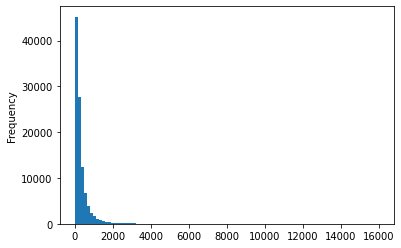

<AxesSubplot:ylabel='Frequency'>

In [0]:
data['len'].plot.hist(bins=100)

In [0]:
data.len.quantile(0.9)

Out[17]: 728.0

In [0]:
data.star_rating.value_counts()

Out[18]: 5 52186
4 18056
1 17572
3 9719
2 7298
Name: star_rating, dtype: int64

### Cleaning

In [0]:
import copy
df = copy.deepcopy(data)

In [0]:
import re

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x
def remove_punctuation(x):
  new_string = re.sub(r'[^\w\s]', '', x)
  return new_string
  

In [0]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
# Usage
replace_contractions("this's a text with contraction")

Out[21]: 'this is a text with contraction'

In [0]:
# lower the text
df["review_body"] = df["review_body"].apply(lambda x: x.lower())

# Clean the text
df["review_body"] = df["review_body"].apply(lambda x: clean_text(x))

# Clean numbers
df["review_body"] = df["review_body"].apply(lambda x: clean_numbers(x))

# Clean Contractions
df["review_body"] = df["review_body"].apply(lambda x: replace_contractions(x))

df["review_body"] = df["review_body"].apply(lambda x: remove_punctuation(x))

In [0]:
count_df = df[['review_body','star_rating']].groupby('review_body').aggregate({'star_rating':'count'}).reset_index().sort_values('star_rating',ascending=False)
count_df.head(120)

Out[23]:

,review_body,star_rating
14751,good,277
98629,works great,218
16607,great,203
11513,excellent,162
18169,great product,132
...,...,...
93589,very nice product,5
100615,yes,5
19513,great value,5
52171,item delivered on time was as described,5


In [0]:
px.bar(count_df[count_df['star_rating']>4],x='review_body',y='star_rating')

Out[24]:

In [0]:
df['len'].max(),df['len'].min(), df['len'].mean()

Out[25]: (16009, 2, 342.49720025564955)

In [0]:
df['len'].describe()

Out[26]: count 104831.000000
mean 342.497200
std 526.515147
min 2.000000
25% 115.000000
50% 190.000000
75% 381.500000
max 16009.000000
Name: len, dtype: float64

Out[27]:

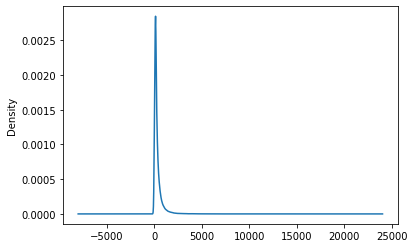

<AxesSubplot:ylabel='Density'>

In [0]:
df['len'].plot.kde()

In [0]:
df.drop("len",inplace = True, axis=1)

In [0]:
df.star_rating.value_counts()

Out[29]: 5 52186
4 18056
1 17572
3 9719
2 7298
Name: star_rating, dtype: int64

In [0]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(df['review_body'], df['star_rating'],
                                                    stratify=df['star_rating'], 
                                                    test_size=0.25)

In [0]:
datatrain = pd.concat([train_X,  train_y], axis =1)
datatest = pd.concat([test_X,  test_y], axis =1)

In [0]:
trainDataset =  spark.createDataFrame(datatrain)
trainDataset.show(10, truncate=50)

+--------------------------------------------------+-----------+
 review_body|star_rating|
+--------------------------------------------------+-----------+
 great item work great| 5|
i bought this to replace my last fm tuner for m...| 5|
excellent sound i am very pleased with this lit...| 5|
the product is exactly as described and works p...| 5|
do not waste your money i have had this armband...| 1|
 great| 5|
asinbdf1e7q usa gear gps vehicle dashboard moun...| 3|
this is truly a good product value for money i ...| 4|
well it took a bit of work getting my phone to ...| 2|
the mini microphone works great as a microphone...| 5|
+--------------------------------------------------+-----------+
only showing top 10 rows

In [0]:
from pyspark.sql.functions import col
trainDataset.groupBy("star_rating") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+-----------+-----+
star_rating|count|
+-----------+-----+
 5|39139|
 4|13542|
 1|13179|
 3| 7289|
 2| 5474|
+-----------+-----+

In [0]:
testDataset  =  spark.createDataFrame(datatest)
testDataset .show(10, truncate=50)

+--------------------------------------------------+-----------+
 review_body|star_rating|
+--------------------------------------------------+-----------+
it is not white at all it is black i hate it it...| 1|
 nice for the price wont take alot of power| 4|
i was so excited when i got it in the mail and ...| 5|
 like | 5|
so happy works as a good replacement and instru...| 5|
an excellent productyou have to play with it a ...| 5|
for iphone repair work love saved a lot of mon...| 5|
plays good but was not constructed very well fa...| 3|
good product for the price it fits perfect over...| 4|
another very good picture but this one is in a ...| 4|
+--------------------------------------------------+-----------+
only showing top 10 rows

In [0]:
testDataset.groupBy("star_rating") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+-----------+-----+
star_rating|count|
+-----------+-----+
 5|13047|
 4| 4514|
 1| 4393|
 3| 2430|
 2| 1824|
+-----------+-----+

In [0]:
%sh
wget https://tfhub.dev/google/universal-sentence-encoder/4?tf-hub-format=compressed  -P /dbfs/tmp/universal


--2022-04-10 13:10:44-- https://tfhub.dev/google/universal-sentence-encoder/4?tf-hub-format=compressed
Resolving tfhub.dev (tfhub.dev)... 74.125.193.102, 74.125.193.139, 74.125.193.100, ...
Connecting to tfhub.dev (tfhub.dev)|74.125.193.102|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.com/tfhub-modules/google/universal-sentence-encoder/4.tar.gz [following]
--2022-04-10 13:10:44-- https://storage.googleapis.com/tfhub-modules/google/universal-sentence-encoder/4.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.193.128, 2a00:1450:400b:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960367946 (916M) [application/x-tar]
Saving to: ‘/dbfs/tmp/universal/4?tf-hub-format=compressed’

 0K .......... .......... .......... .......... .......... 0% 6.24M 2m27s
 50K .......... .......... .......... .......... .......... 0% 11.7M 1m52s
 100K .......... .......... .......... .......... .......... 0% 11.3M 1m42s
 150K .......... .......... .......... .......... .......... 0% 12.4M 95s
 200K .......... .......... .......... .......... .......... 0% 11.0M 93s
 250K .......... .......... .......... .......... .......... 0% 10.9M 91s
 300K .......... .......... .......... .......... .......... 0% 11.3M 90s
 350K .......... .......... .......... .......... .......... 0% 11.7M 88s
 400K .......... .......... .......... .......... .......... 0% 10.6M 88s
 450K .......... .......... .......... .......... .......... 0% 11.0M 88s
 500K .......... .......... .......... .......... .......... 0% 10.8M 87s
 550K .......... .......... .......... .......... .......... 0% 11.4M 87s
 600K .......... .......... .......... .......... .......... 0% 11.3M 86s
 650K .......... .......... .......... .......... .......... 0% 11.9M 86s
 700K .......... .......... .......... .......... .......... 0% 11.6M 85s
 750K .......... .......... .......... .......... .......... 0% 11.1M 85s
 800K .......... .......... .......... .......... .......... 0% 11.2M 85s
 850K .......... .......... .......... .......... .......... 0% 11.8M 84s
 900K .......... .......... .......... .......... .......... 0% 11.5M 84s
 950K .......... .......... .......... .......... .......... 0% 11.7M 84s
 1000K .......... .......... .......... .......... .......... 0% 13.3M 83s
 1050K .......... .......... .......... .......... .......... 0% 26.9M 81s
 1100K .......... .......... .......... .......... .......... 0% 31.9M 79s
 1150K .......... .......... .......... .......... .......... 0% 22.5M 77s
 1200K .......... .......... .......... .......... .......... 0% 28.4M 75s
 1250K .......... .......... .......... .......... .......... 0% 30.0M 73s
 1300K .......... .......... .......... .......... .......... 0% 28.8M 72s
 1350K .......... .......... .......... .......... .......... 0% 21.9M 71s
 1400K .......... .......... .......... .......... .......... 0% 30.6M 69s
 1450K .......... .......... .......... .......... .......... 0% 27.6M 68s
 1500K .......... .......... .......... .......... .......... 0% 29.2M 67s
 1550K .......... .......... .......... .......... .......... 0% 24.7M 66s
 1600K .......... .......... .......... .......... .......... 0% 27.6M 65s
 1650K .......... .......... .......... .......... .......... 0% 27.9M 64s
 1700K .......... .......... .......... .......... .......... 0% 30.3M 63s
 1750K .......... .......... .......... .......... .......... 0% 25.8M 62s
 1800K .......... .......... .......... .......... .......... 0% 30.7M 61s
 1850K .......... .......... .......... .......... .......... 0% 31.2M 61s
 1900K .......... .......... .......... .......... .......... 0% 25.8M 60s
 1950K .......... .......... .......... .......... .......... 0% 23.5M 59s
 2000K .......... .......... .......... .......... .......... 0% 23.8M 59s
 2050K .......... .......... .......... .......... ..........

In [0]:
dbutils.fs.ls("/tmp/universal")

Out[54]: [FileInfo(path='dbfs:/tmp/universal/4?tf-hub-format=compressed', name='4?tf-hub-format=compressed', size=960367946)]

In [0]:
%sh
mv /dbfs/tmp/universal/4?tf-hub-format=compressed /dbfs/tmp/universal/UniversalSentenceEncoder.targ.gz


In [0]:
%sh
ls -l /dbfs/tmp/universal/

total 1011180
-rwxrwxrwx 1 root root 1035448320 Apr 10 13:14 UniversalSentenceEncoder.targ

In [0]:
%sh
gunzip /dbfs/tmp/universal/UniversalSentenceEncoder.targ.gz

In [0]:
%sh
tar -xvf /dbfs/tmp/universal/UniversalSentenceEncoder.targ -C /dbfs/tmp/universal/

./
./assets/
./variables/
./variables/variables.index
./variables/variables.data-00000-of-00001
./saved_model.pb

In [0]:
dbutils.fs.ls("tmp/universal/")

Out[74]: [FileInfo(path='dbfs:/tmp/universal/UniversalSentenceEncoder.targ', name='UniversalSentenceEncoder.targ', size=1035448320),
 FileInfo(path='dbfs:/tmp/universal/assets/', name='assets/', size=0),
 FileInfo(path='dbfs:/tmp/universal/saved_model.pb', name='saved_model.pb', size=8224055),
 FileInfo(path='dbfs:/tmp/universal/variables/', name='variables/', size=0)]

In [0]:
# actual content is inside description column
document = DocumentAssembler()\
    .setInputCol("review_body")\
    .setOutputCol("document")
    
# we can also use sentence detector here 
# if we want to train on and get predictions for each sentence
# downloading pretrained embeddings
use = UniversalSentenceEncoder.load('/dbfs/tmp/universal/saved_model.pb')\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")
# the classes/labels/categories are in category column
classsifierdl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("star_rating")\
  .setMaxEpochs(5)\
  .setEnableOutputLogs(True)
use_clf_pipeline = Pipeline(
    stages = [
        document,
        use,
        classsifierdl
    ])

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 <command-242455> in <module> 
 7 # if we want to train on and get predictions for each sentence 
 8 # downloading pretrained embeddings 
 ----> 9 use = UniversalSentenceEncoder . load ( '/dbfs/tmp/universal/saved_model.pb' ) \ 
 10 . setInputCols ( [ "document" ] ) \ 
 11 . setOutputCol ( "sentence_embeddings" ) 

 /databricks/spark/python/pyspark/ml/util.py in load (cls, path) 
 461 def load ( cls , path ) : 
 462 """Reads an ML instance from the input path, a shortcut of `read().load(path)`.""" 
 --> 463 return cls . read ( ) . load ( path ) 
 464 
 465 

 /databricks/spark/python/pyspark/ml/util.py in load (self, path) 
 411 if not isinstance ( path , str ) : 
 412 raise TypeError ( "path should be a string, got type %s" % type ( path ) ) 
 --> 413 java_obj = self . _jread . load ( path ) 
 414 if not hasattr ( self . _clazz , "_from_java" ) : 
 415 raise NotImplementedError("This Java ML type cannot be loaded into Python currently: %r"

 /databricks/spark/python/lib/py4j-0.10.9.1-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1302 
 1303 answer = self . gateway_client . send_command ( command ) 
 -> 1304 return_value = get_return_value(
 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 115 def deco ( * a , ** kw ) : 
 116 try : 
 --> 117 return f ( * a , ** kw ) 
 118 except py4j . protocol . Py4JJavaError as e : 
 119 converted = convert_exception ( e . java_exception ) 

 /databricks/spark/python/lib/py4j-0.10.9.1-src.zip/py4j/protocol.py in get_return_value (answer, gateway_client, target_id, name) 
 324 value = OUTPUT_CONVERTER [ type ] ( answer [ 2 : ] , gateway_client ) 
 325 if answer [ 1 ] == REFERENCE_TYPE : 
 --> 326 raise Py4JJavaError(
 327 "An error occurred while calling {0}{1}{2}.\n" . 
 328 format(target_id, ".", name), value)

 Py4JJavaError : An error occurred while calling o2097.load.
: org.apache.hadoop.mapred.InvalidInputException: Input path does not exist: /dbfs/tmp/universal/saved_model.pb/metadata
	at org.apache.hadoop.mapred.FileInputFormat.singleThreadedListStatus(FileInputFormat.java:304)
	at org.apache.hadoop.mapred.FileInputFormat.listStatus(FileInputFormat.java:244)
	at org.apache.hadoop.mapred.FileInputFormat.getSplits(FileInputFormat.java:332)
	at org.apache.spark.rdd.HadoopRDD.getPartitions(HadoopRDD.scala:213)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:307)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:303)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:57)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:307)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:303)
	at org.apache.spark.rdd.RDD.$anonfun$take$1(RDD.scala:1440)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:165)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:125)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:419)
	at org.apache.spark.rdd.RDD.take(RDD.scala:1434)
	at org.apache.spark.rdd.RDD.$anonfun$first$1(RDD.scala:1475)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:165)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:125)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:419)
	at org.apache.spark.rdd.RDD.first(RDD.scala:1475)
	at org.apache.spark.ml.util.DefaultParamsReader$.loadMetadata(ReadWrite.scala:587)
	at org.apache.spark.ml.util.DefaultParamsReader.load(ReadWrite.scala:465)
	at com.johnsnowlabs.nlp.FeaturesReader.load(ParamsAndFeaturesReadable.scala:12)
	

In [0]:
%sh
python -m spacy download en_core_web_sm

Collecting en-core-web-sm==3.1.0
 Downloading https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.1.0/en_core_web_sm-3.1.0-py3-none-any.whl (13.6 MB)
Requirement already satisfied: spacy<3.2.0,>=3.1.0 in /databricks/python3/lib/python3.8/site-packages (from en-core-web-sm==3.1.0) (3.1.3)
Requirement already satisfied: murmurhash<1.1.0,>=0.28.0 in /databricks/python3/lib/python3.8/site-packages (from spacy<3.2.0,>=3.1.0->en-core-web-sm==3.1.0) (1.0.5)
Requirement already satisfied: pydantic!=1.8,!=1.8.1,<1.9.0,>=1.7.4 in /databricks/python3/lib/python3.8/site-packages (from spacy<3.2.0,>=3.1.0->en-core-web-sm==3.1.0) (1.8.2)
Requirement already satisfied: setuptools in /usr/local/lib/python3.8/dist-packages (from spacy<3.2.0,>=3.1.0->en-core-web-sm==3.1.0) (52.0.0)
Requirement already satisfied: tqdm<5.0.0,>=4.38.0 in /databricks/python3/lib/python3.8/site-packages (from spacy<3.2.0,>=3.1.0->en-core-web-sm==3.1.0) (4.59.0)
Requirement already satisfied: typer<0.5.0,>=0.3.0 in /databricks/python3/lib/python3.8/site-packages (from spacy<3.2.0,>=3.1.0->en-core-web-sm==3.1.0) (0.3.2)
Requirement already satisfied: pathy>=0.3.5 in /databricks/python3/lib/python3.8/site-packages (from spacy<3.2.0,>=3.1.0->en-core-web-sm==3.1.0) (0.6.0)
Requirement already satisfied: requests<3.0.0,>=2.13.0 in /databricks/python3/lib/python3.8/site-packages (from spacy<3.2.0,>=3.1.0->en-core-web-sm==3.1.0) (2.25.1)
Requirement already satisfied: preshed<3.1.0,>=3.0.2 in /databricks/python3/lib/python3.8/site-packages (from spacy<3.2.0,>=3.1.0->en-core-web-sm==3.1.0) (3.0.5)
Requirement already satisfied: srsly<3.0.0,>=2.4.1 in /databricks/python3/lib/python3.8/site-packages (from spacy<3.2.0,>=3.1.0->en-core-web-sm==3.1.0) (2.4.1)
Requirement already satisfied: wasabi<1.1.0,>=0.8.1 in /databricks/python3/lib/python3.8/site-packages (from spacy<3.2.0,>=3.1.0->en-core-web-sm==3.1.0) (0.8.2)
Requirement already satisfied: jinja2 in /databricks/python3/lib/python3.8/site-packages (from spacy<3.2.0,>=3.1.0->en-core-web-sm==3.1.0) (2.11.3)
Requirement already satisfied: cymem<2.1.0,>=2.0.2 in /databricks/python3/lib/python3.8/site-packages (from spacy<3.2.0,>=3.1.0->en-core-web-sm==3.1.0) (2.0.5)
Requirement already satisfied: numpy>=1.15.0 in /databricks/python3/lib/python3.8/site-packages (from spacy<3.2.0,>=3.1.0->en-core-web-sm==3.1.0) (1.19.2)
Requirement already satisfied: spacy-legacy<3.1.0,>=3.0.8 in /databricks/python3/lib/python3.8/site-packages (from spacy<3.2.0,>=3.1.0->en-core-web-sm==3.1.0) (3.0.8)
Requirement already satisfied: packaging>=20.0 in /databricks/python3/lib/python3.8/site-packages (from spacy<3.2.0,>=3.1.0->en-core-web-sm==3.1.0) (20.9)
Requirement already satisfied: catalogue<2.1.0,>=2.0.6 in /databricks/python3/lib/python3.8/site-packages (from spacy<3.2.0,>=3.1.0->en-core-web-sm==3.1.0) (2.0.6)
Requirement already satisfied: thinc<8.1.0,>=8.0.9 in /databricks/python3/lib/python3.8/site-packages (from spacy<3.2.0,>=3.1.0->en-core-web-sm==3.1.0) (8.0.9)
Requirement already satisfied: blis<0.8.0,>=0.4.0 in /databricks/python3/lib/python3.8/site-packages (from spacy<3.2.0,>=3.1.0->en-core-web-sm==3.1.0) (0.7.4)
Requirement already satisfied: pyparsing>=2.0.2 in /databricks/python3/lib/python3.8/site-packages (from packaging>=20.0->spacy<3.2.0,>=3.1.0->en-core-web-sm==3.1.0) (2.4.7)
Requirement already satisfied: smart-open<6.0.0,>=5.0.0 in /databricks/python3/lib/python3.8/site-packages (from pathy>=0.3.5->spacy<3.2.0,>=3.1.0->en-core-web-sm==3.1.0) (5.2.0)
Requirement already satisfied: typing-extensions>=3.7.4.3 in /databricks/python3/lib/python3.8/site-packages (from pydantic!=1.8,!=1.8.1,<1.9.0,>=1.7.4->spacy<3.2.0,>=3.1.0->en-core-web-sm==3.1.0) (4.1.1)
Requirement already satisfied: certifi>=2017.4.17 in /databricks/python3/lib/python3.8/site-packages (from requests<3.0.0,>=2.13.0->spacy<3.2.0,>=3.1.0->en-core-web-sm==3.1.0) (2020.12.5)
Requirement already satisfied: chardet<5,>=3.0.2 in /databricks/

In [0]:
#tokenization
tok = spacy.load('en_core_web_sm')
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

In [0]:
#count number of occurences of each word
counts = Counter()
for index, row in reviews.iterrows():
    counts.update(tokenize(row['review']))

In [0]:
#count number of occurences of each word
counts 

Out[93]: Counter({'as': 36506,
 'advertised': 1755,
 'everything': 3715,
 'works': 18034,
 'perfectly': 5012,
 'i': 227739,
 'am': 19229,
 'very': 32410,
 'happy': 4945,
 'with': 62177,
 'the': 366867,
 'camera': 4894,
 'a': 162793,
 'matter': 943,
 'of': 80682,
 'fact': 1862,
 'going': 4083,
 'to': 179214,
 'buy': 10741,
 'another': 5744,
 'one': 29386,
 'for': 94636,
 'my': 82356,
 ' ': 181515,
 'nd': 728,
 'car': 10402,
 'it': 218074,
 'is': 140505,
 'great': 32120,
 'these': 11672,
 'work': 15651,
 'and': 181163,
 'fit': 9469,
 'life': 2369,
 'proof': 306,
 'case': 27046,
 'iphone': 7520,
 'well': 18425,
 'but': 52920,
 'could': 10085,
 'not': 103624,
 'get': 18237,
 'used': 8215,
 'hearing': 367,
 'anything': 2790,
 'out': 20236,
 'ear': 1203,
 'they': 22054,
 'v': 998,
 'were': 7160,
 'plugged': 2470,
 'into': 8008,
 'be': 27781,
 'careful': 703,
 'products': 2243,
 'have': 57095,
 'bought': 12968,
 'several': 2760,
 'cameras': 426,
 'image': 552,
 'pretty': 5528,
 'decent': 1579,
 'battery': 9961,
 'does': 21181,
 'hold': 3796,
 'any': 9712,
 'charge': 8402,
 'appears': 780,
 'good': 25605,
 'still': 8659,
 'waiting': 506,
 'other': 12411,
 'items': 1470,
 'radiobatteriescharger': 1,
 'before': 5024,
 'can': 27639,
 'go': 6067,
 ' ': 38253,
 'or': 24083,
 'stars': 2777,
 'first': 8118,
 'arrived': 2845,
 'brick': 108,
 'would': 28792,
 'useless': 1148,
 'exchanged': 60,
 'new': 7434,
 'that': 65512,
 'worked': 6576,
 'vacation': 232,
 'this': 98828,
 'item': 7705,
 'provide': 808,
 'me': 16285,
 'sound': 15073,
 'like': 21228,
 'love': 10046,
 'recorder': 306,
 'obviously': 488,
 'because': 11615,
 'tape': 1109,
 'cassettes': 110,
 'no': 19209,
 'way': 7459,
 'play': 4299,
 'thembr': 149,
 'spent': 809,
 'an': 19490,
 'amazing': 1987,
 'afternoon': 72,
 'listening': 1379,
 'mom': 285,
 'who': 3582,
 'passed': 120,
 'away': 2942,
 'in': 70669,
 'tell': 1810,
 'minute': 611,
 'christmas': 1553,
 'story': 182,
 'nicholas': 1,
 'two': 7519,
 'daughters': 552,
 'many': 3889,
 'moons': 1,
 'ago': 1647,
 'was': 55728,
 'wonderful': 859,
 'laughter': 3,
 'tearsbr': 1,
 'thank': 1419,
 'you': 58430,
 'providing': 188,
 'time': 14106,
 'spend': 1183,
 'again': 5666,
 'beach': 294,
 'park': 182,
 'anywhere': 805,
 'lasts': 623,
 'if': 25151,
 'what': 15169,
 'want': 6609,
 'continuous': 144,
 'tone': 221,
 'piezo': 3,
 'ie': 285,
 'beeper': 6,
 'then': 8601,
 ' ': 12616,
 'maybe': 1890,
 'possibly': 260,
 'dock': 1554,
 'star': 1454,
 'bit': 4696,
 'quiet': 254,
 'rated': 485,
 'level': 820,
 'however': 4796,
 'wanted': 3991,
 'thing': 7203,
 'described': 1395,
 'listing': 192,
 'buzzer': 33,
 'example': 351,
 'something': 4816,
 'make': 5732,
 'answer': 464,
 'incorrectly': 29,
 'on': 59956,
 'game': 428,
 'show': 1218,
 'bzzzzt': 1,
 'at': 23019,
 'best': 5096,
 'rd': 654,
 'batch': 62,
 'buzzers': 2,
 'ordered': 4075,
 'from': 22401,
 'different': 4155,
 'suppliers': 23,
 'so': 34733,
 'isolated': 29,
 'incident': 53,
 'anyone': 2777,
 'need': 7249,
 'some': 9705,
 'beepers': 4,
 'cheap': 4772,
 'sucks': 397,
 'u': 840,
 'plug': 4315,
 'both': 4204,
 'mhd': 9,
 'flasher': 11,
 'android': 885,
 'flash': 621,
 'performance': 750,
 'tunes': 234,
 'bmw': 178,
 'ii': 154,
 'n': 514,
 'engines': 17,
 'just': 23347,
 'read': 3599,
 'instructions': 2750,
 'attacked': 4,
 'key': 1828,
 'chain': 161,
 'installed': 2630,
 'unable': 334,
 'close': 1512,
 'cap': 198,
 'times': 3344,
 'apparently': 384,
 'broken': 1245,
 'tried': 4476,
 'did': 16863,
 'mange': 3,
 'yet': 2707,
 'surely': 88,
 'quality': 13839,
 'cover': 7815,
 'device': 8267,
 'thinking': 850,
 'returning': 775,
 'look': 4266,
 'better': 8747,
 'font': 118,
 'are': 28506,
 'too': 8680,
 'tiny': 967,
 'sure': 4426,
 'afford': 133,
 'larger': 898,
 'print': 302,
 'phone': 10473,
 'number': 1022,
 'web': 450,
 'address': 331,
 'contact': 771,
 'replacement': 2312,
 'hmmmmaybe': 2,
 'knew': 597,
 'had': 21186,
 'inferior': 107,
 'care': 889,
 'deal': 2548,
 'complaints': 808,
 '

In [0]:
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 77346
num_words after: 33052

In [0]:
#creating vocabulary
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [0]:
def encode_sentence(text, vocab2index, N=70):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [0]:
reviews['encoded'] = reviews['review'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
reviews.head()

<command-242388>:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

Out[98]:

,review,rating,review_length,encoded
0,as advertised everything works perfectly i am ...,4,28,"[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 2, 1..."
1,it is great,4,3,"[[28, 29, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,these work great and fit my life proof case fo...,4,13,"[[31, 32, 30, 33, 34, 24, 35, 36, 37, 23, 12, ..."
3,work very well but could not get used to not h...,3,21,"[[32, 9, 39, 40, 41, 42, 43, 44, 19, 42, 45, 4..."
4,be careful with these products i have bought s...,1,25,"[[54, 55, 11, 31, 56, 7, 57, 58, 59, 16, 31, 6..."


In [0]:
#check how balanced the dataset is
Counter(reviews['rating'])

Out[99]: Counter({4: 52186, 3: 18056, 1: 7298, 2: 9719, 0: 17572})

In [0]:
X = list(reviews['encoded'])
y = list(reviews['rating'])
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [0]:
class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [0]:
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)

In [0]:
def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long()
            y = y.long()
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        if i % 5 == 1:
            print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))

def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total
  

In [0]:
batch_size = 5000
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

### LSTM with fixed length input

In [0]:
class LSTM_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])
model_fixed =  LSTM_fixed_len(vocab_size, 50, 50)

In [0]:
train_model(model_fixed, epochs=30, lr=0.01)

train loss 1.347, val loss 1.346, val accuracy 0.501, and val rmse 1.941
train loss 1.192, val loss 1.184, val accuracy 0.580, and val rmse 1.525
train loss 1.160, val loss 1.161, val accuracy 0.576, and val rmse 1.567
train loss 1.078, val loss 1.124, val accuracy 0.592, and val rmse 1.422
train loss 1.073, val loss 1.123, val accuracy 0.601, and val rmse 1.331
train loss 1.017, val loss 1.071, val accuracy 0.597, and val rmse 1.381

### LSTM with variable length input

In [0]:
class LSTM_variable_input(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        
    def forward(self, x, s):
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        out = self.linear(ht[-1])
        return out

In [0]:
# model = LSTM_variable_input(vocab_size, 50, 50)
# train_model(model, epochs=30, lr=0.1)

In [0]:
dbutils.fs.ls("/tmp/glove")

Out[34]: [FileInfo(path='dbfs:/tmp/glove/download', name='download', size=6587),
 FileInfo(path='dbfs:/tmp/glove/glove.840B.300d.txt', name='glove.840B.300d.txt', size=5646236541),
 FileInfo(path='dbfs:/tmp/glove/glove.840B.300d.zip', name='glove.840B.300d.zip', size=2176768927),
 FileInfo(path='dbfs:/tmp/glove/glove.840B.300d.zip.1', name='glove.840B.300d.zip.1', size=2176768927),
 FileInfo(path='dbfs:/tmp/glove/models/', name='models/', size=0)]

In [0]:
def load_glove_vectors(glove_file='/dbfs/tmp/glove/glove.840B.300d.txt'):#"./data/glove.6B/glove.6B.50d.txt"
    """Load the glove word vectors"""
    word_vectors = {}
    with open(glove_file) as f:
        for line in f:
            split = line.split()
            word_vectors[split[0]] = np.array([float(x) for x in split[1:]])
    return word_vectors

In [0]:
def get_emb_matrix(pretrained, word_counts, emb_size = 300):
    """ Creates embedding matrix from word vectors"""
    vocab_size = len(word_counts) + 2
    vocab_to_idx = {}
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
    vocab_to_idx["UNK"] = 1
    i = 2
    for word in word_counts:
        if word in word_vecs:
            W[i] = word_vecs[word]
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
        vocab_to_idx[word] = i
        vocab.append(word)
        i += 1   
    return W, np.array(vocab), vocab_to_idx

In [0]:
%sh
nvidia-smi

Sun Apr 10 11:00:22 2022 
+-----------------------------------------------------------------------------+
 NVIDIA-SMI 470.57.02 Driver Version: 470.57.02 CUDA Version: 11.4 |
-------------------------------+----------------------+----------------------+
 GPU Name Persistence-M| Bus-Id Disp.A | Volatile Uncorr. ECC |
 Fan Temp Perf Pwr:Usage/Cap| Memory-Usage | GPU-Util Compute M. |
 | | MIG M. |
===============================+======================+======================|
 0 Tesla T4 Off | 00000000:00:1E.0 Off | 0 |
 N/A 81C P0 77W / 70W | 5473MiB / 15109MiB | 96% Default |
 | | N/A |
+-------------------------------+----------------------+----------------------+
 
+-----------------------------------------------------------------------------+
 Processes: |
 GPU GI CI PID Type Process name GPU Memory |
 ID ID Usage |
=============================================================================|
+-----------------------------------------------------------------------------+

In [0]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

In [0]:
n_epochs = 20
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

<command-241534>:48: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

Epoch 1/20 loss=596.4397 val_loss=515.7928 val_acc=0.5755 time=152.24s
Epoch 2/20 loss=490.7367 val_loss=461.0382 val_acc=0.6359 time=161.65s
Epoch 3/20 loss=430.1489 val_loss=406.6558 val_acc=0.6908 time=161.83s
Epoch 4/20 loss=383.4416 val_loss=369.8621 val_acc=0.7264 time=162.79s
Epoch 5/20 loss=348.4224 val_loss=336.7896 val_acc=0.7530 time=161.43s
Epoch 6/20 loss=320.3503 val_loss=315.4732 val_acc=0.7734 time=160.95s
Epoch 7/20 loss=299.1353 val_loss=295.2615 val_acc=0.7904 time=161.01s
Epoch 8/20 loss=280.7748 val_loss=285.9260 val_acc=0.7952 time=160.66s
Epoch 9/20 loss=267.2628 val_loss=270.9959 val_acc=0.8085 time=160.88s
Epoch 10/20 loss=254.4529 val_loss=261.1858 val_acc=0.8143 time=161.21s
Epoch 11/20 loss=243.8827 val_loss=253.4044 val_acc=0.8200 time=162.39s
Epoch 12/20 loss=235.7342 val_loss=249.3268 val_acc=0.8243 time=161.22s
Epoch 13/20 loss=226.7463 val_loss=237.5348 val_acc=0.8338 time=162.39s
Epoch 14/20 loss=221.1302 val_loss=234.2655 val_acc=0.8358 time=162.21s
Epoch 15/20 loss=213.7214 val_loss=231.3820 val_acc=0.8399 time=161.46s
Epoch 16/20 loss=208.8605 val_loss=230.0421 val_acc=0.8389 time=162.95s
Epoch 17/20 loss=203.6600 val_loss=221.1926 val_acc=0.8463 time=163.98s
Epoch 18/20 loss=199.2544 val_loss=223.4778 val_acc=0.8469 time=163.78s
Epoch 19/20 loss=194.3148 val_loss=215.6584 val_acc=0.8546 time=163.53s
Epoch 20/20 loss=190.0668 val_loss=219.4935 val_acc=0.8519 time=162.99s

In [0]:
dbutils.fs.mkdirs("/tmp/glove/models")

Out[51]: True

In [0]:
torch.save(model,'/dbfs/tmp/glove/models/textcnn_model_glove')

In [0]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

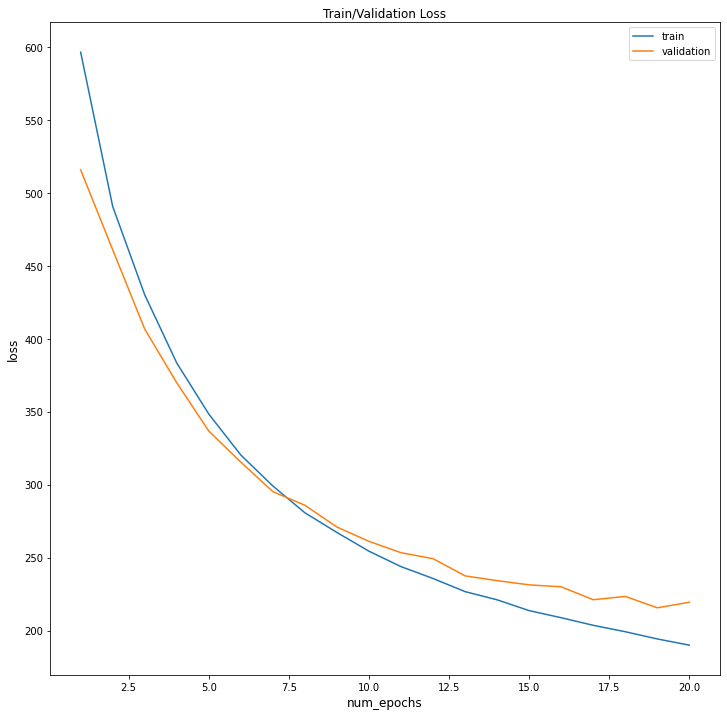

In [0]:
plot_graph(n_epochs)

Out[55]:

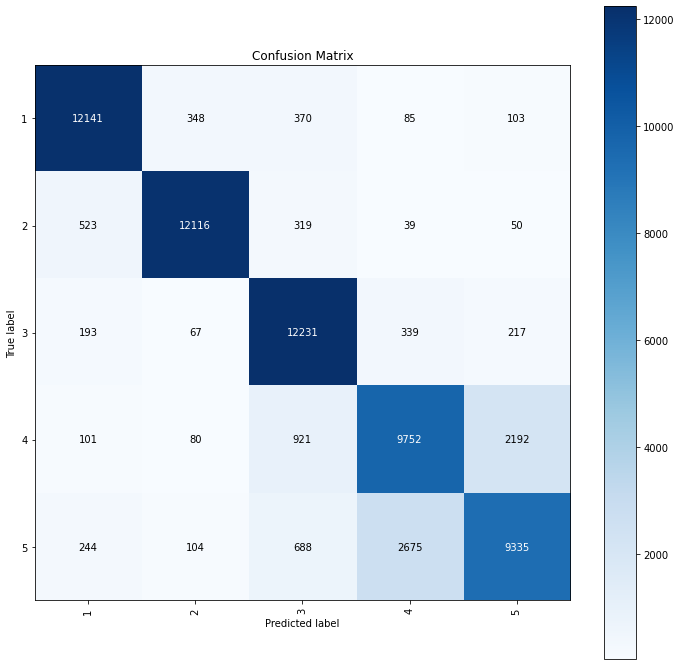

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

In [0]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

In [0]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [0]:
n_epochs = 20
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

<command-241541>:48: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

Epoch 1/20 loss=627.0122 val_loss=544.8769 val_acc=0.5302 time=88.32s
Epoch 2/20 loss=522.8968 val_loss=494.7609 val_acc=0.5758 time=88.38s
Epoch 3/20 loss=478.9558 val_loss=464.3841 val_acc=0.6080 time=87.12s
Epoch 4/20 loss=434.4098 val_loss=435.3991 val_acc=0.6425 time=87.41s
Epoch 5/20 loss=389.2329 val_loss=426.7794 val_acc=0.6509 time=88.54s
Epoch 6/20 loss=346.3888 val_loss=374.9777 val_acc=0.7094 time=87.43s
Epoch 7/20 loss=304.1625 val_loss=332.6226 val_acc=0.7531 time=88.75s
Epoch 8/20 loss=269.1803 val_loss=296.9352 val_acc=0.7865 time=87.34s
Epoch 9/20 loss=237.6341 val_loss=283.6864 val_acc=0.7969 time=88.37s
Epoch 10/20 loss=211.7010 val_loss=259.5039 val_acc=0.8177 time=88.20s
Epoch 11/20 loss=188.4854 val_loss=251.2787 val_acc=0.8291 time=87.67s
Epoch 12/20 loss=171.3803 val_loss=237.3465 val_acc=0.8369 time=89.25s
Epoch 13/20 loss=157.6207 val_loss=228.5628 val_acc=0.8470 time=88.59s
Epoch 14/20 loss=143.0988 val_loss=209.4859 val_acc=0.8608 time=88.26s
Epoch 15/20 loss=132.5498 val_loss=207.9527 val_acc=0.8648 time=88.49s
Epoch 16/20 loss=123.7151 val_loss=216.6261 val_acc=0.8613 time=88.80s
Epoch 17/20 loss=124.3995 val_loss=240.8472 val_acc=0.8521 time=88.99s
Epoch 18/20 loss=105.4340 val_loss=245.2376 val_acc=0.8520 time=88.78s
Epoch 19/20 loss=101.6092 val_loss=200.1681 val_acc=0.8827 time=88.70s
Epoch 20/20 loss=96.4088 val_loss=215.6955 val_acc=0.8738 time=88.94s

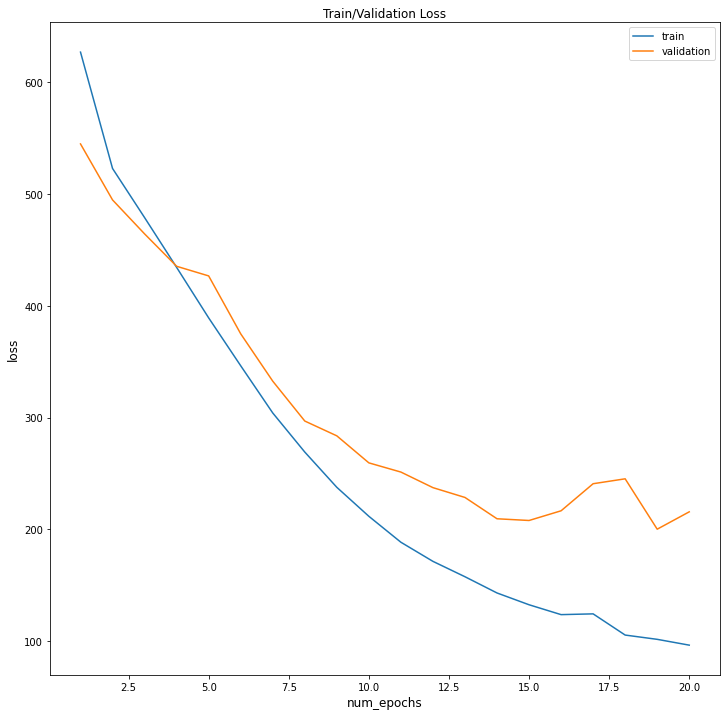

In [0]:
plot_graph(n_epochs)

In [0]:
torch.save(model,'/dbfs/tmp/glove/models/bilstm_model_glove')

Out[60]:

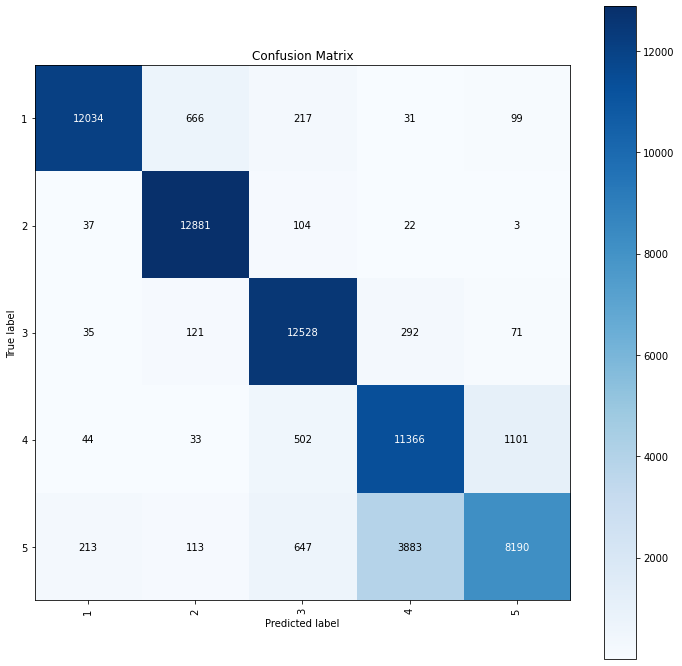

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

In [0]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)